# K-means Clustering

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np


# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

%load_ext autoreload
%autoreload 2


# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately
in the next sections.

<a id="section1"></a>
#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Your task is to complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
<a id="findClosestCentroids"></a>

In [2]:
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    """
    arr = np.zeros((X.shape[0],centroids.shape[0]))
    for i in range(centroids.shape[0]):
        n = np.sum((X - centroids[i])**2,axis=1)
        arr[:,i] = n

    idx = np.argmin(arr,axis=1)
    return idx

Once you have completed the code in `findClosestCentroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [3]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


<a id="section2"></a>
### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.



In [6]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    """
    centroids = np.zeros((K,X.shape[1]))
    for i in range(K):
        center = np.mean(X[idx==i],axis=0)
        centroids[i,:] = center 
    return centroids

Once you have completed the code in `computeCentroids`, the following cell will run your code and output the centroids after the first step of K-means.

In [7]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


### 1.2 K-means on example dataset 

After you have completed the two functions (`findClosestCentroids` and `computeCentroids`), you have all the necessary pieces to run the K-means algorithm. The next cell  will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the `runKmeans` function (in this assignment's `utils.py` module). We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop.

When you run the next step, the K-means code will produce an animation that steps you through the progress of the algorithm at each iteration. At the end, your figure should look as the one displayed below.

![](Figures/kmeans_result.png)

In [8]:
# Load an example dataset
data = loadmat(os.path.join('Data', 'ex7data2.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = utils.runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
#anim

<Figure size 432x288 with 0 Axes>

### 1.3 Random initialization 

The initial assignments of centroids for the example dataset in the previous cell were designed so that you will see the same figure as that shown in the cell above. In practice, a
good strategy for initializing the centroids is to select random examples from the training set.



In [9]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    
    Instructions
    ------------
    You should set centroids to randomly chosen examples from the dataset X.
    """
    centroids = X[np.random.randint(0,X.shape[0],K)]
    return centroids

In [10]:
def k_kmeans(X,K,num_iter):
    centroids = kMeansInitCentroids(X,K)
    for i in range(num_iter):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
    return idx , centroids

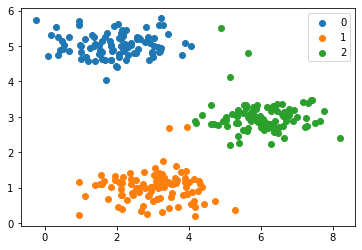

In [15]:
import matplotlib.pyplot as plt

idx , centroids = k_kmeans(X,3,500)
for i in range(3):
    plt.scatter(X[idx==i][:,0],X[idx==i][:,1],label=i)
plt.legend()

In [16]:
idx

array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0], d

In [157]:
class k_means():
    
    def __init__(self,K):
        self.K = K
        self.centroids = np.zeros((1,K))
        self._label = 0
        
    def kMeansInitCentroids(self,X,K):
        centroids = X[np.random.randint(0,X.shape[0],K)]
        return centroids
    
    def findClosestCentroids(self,X, centroids):
        arr = np.zeros((X.shape[0],centroids.shape[0]))
        for i in range(centroids.shape[0]):
            n = np.sum((X - centroids[i])**2,axis=1)
            arr[:,i] = n
        idx = np.argmin(arr,axis=1)
        return idx
    
    def computeCentroids(self,X, idx, K):
        centroids = np.zeros((K,X.shape[1]))
        for i in range(K):
            center = np.mean(X[idx==i],axis=0)
            centroids[i,:] = center 
        return centroids
    
    def fit(self,X,num_iter = 200):
        # to find best init of centroids to avoid local minimum 
        best_init = {}
        for t in range(10):
            # init random centroids
            cen = self.kMeansInitCentroids(X,self.K) 
            
            for i in range(num_iter):
                idx = self.findClosestCentroids(X, cen)
                centroids = self.computeCentroids(X, idx, self.K)
                # stop condition
                distance = np.linalg.norm(centroids - cen)
                if distance < 2: 
                    print(f"stop at iteration :{i}")
                    break       
                cen = centroids
            # calculate variance to know which one is the best initiaion
            labels = self.findClosestCentroids(X,centroids)
            var_t = []
            for centr in range(centroids.shape[0]):
                index = [index for index, value in enumerate(labels) if value == centr]
                var_t.append(np.sum((X[index] - centroids[centr])**2))         
            best_init[np.mean(var_t)] = centroids
        
        centroids = best_init[min(best_init.keys())]
        self.centroids = centroids
        self._label = self.findClosestCentroids(X,self.centroids)

In [158]:
data = loadmat(os.path.join('Data', 'ex7data2.mat'))

In [159]:
clusters = 3
k1 = k_means(clusters)
k1.fit(data['X'])

stop at iteration :1
stop at iteration :1
stop at iteration :1
stop at iteration :0
stop at iteration :1
stop at iteration :1
stop at iteration :1
stop at iteration :0
stop at iteration :1
stop at iteration :0


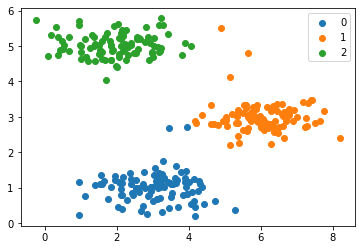

In [160]:
import matplotlib.pyplot as plt

idx = k1._label
for i in range(clusters):
    plt.scatter(data['X'][idx==i][:,0],data['X'][idx==i][:,1],label=i)
plt.legend()